# Pre Processing: Feature Selection

Feature Selection is an important step in data pre-processing. It consists in selecting the best subset of input variable as the most pertinent. Discarding irrelevant data is essential before applying Machine Learning algorithm in order to:
* *Reduce Overfitting*: less opportunity to make decisions based on noise;
* *Improve Accuracy*: less misleading data means modelling accuracy improves. Predictions can be greatly distorted by redundant attributes. 
* *Reduce Training Time*: With less data the algorithms will train faster;


### Import Libraries

In [1]:
import scipy.stats as stats
import geopandas as gpd
import numpy as np
from fs import methods as m
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, clear_output
from sklearn import preprocessing
import os
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import AppLayout

/Users/Brescia/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Dataframe 

In [2]:
geopackages = os.listdir('grids')
geopackages.remove('.DS_Store')
grid_data = []
dataframes_results = {}
var_t = 'empty'

## Results Feature Selection
In this section fs results are evaluated for each geopackages contained in the folder [grids/](https://github.com/opengeolab/D-DUST/tree/thesis_MB/notebooks/grids).<br />
The results are stored in a list of dataframe (one for each dataset) and are displayed in n bar plot. <br />
Each subplot refers to the method choosen with the dropdown widgets, with the possiblity to normalized results or not. <br />
The methods used are:

* Pearson correlation;
* Spearmanr correlation;
* Kendall tau; 
* F-Test;
* Random Forest importance; 

<br />
In addition, an average score for these methods is added.



In [3]:
results_norm = widgets.Checkbox(
    value=True,
    description='Results normalized',
    disabled=False,
    indent=True
)

#Radiobutton used to display data in regular or logaritmic scale
scale = widgets.RadioButtons(
    options=['Regular', 'Logaritmic'],
    description='Scale:',
    disabled=False
)

#Radiobutton used to display data ordered by score or by labels
order = widgets.RadioButtons(
    options=['Labels', 'Scores'],
    description='Order by:',
    disabled=False
)
#Dropdown widgets used to choose the scores of the method selected
method_choosen = widgets.Dropdown(
    options=['Pearson', 'Spearmanr', 'Kendall', 'Fisher', 'RF Importance', 'Average Scores'],
    value='Pearson',
    description='Method:',
    disabled=False
)

target_variable = widgets.Dropdown(
    options=['pm25_st','pm25_cams'],
    value='pm25_cams',
    description='Target:'
)

variance_TH= widgets.Checkbox(
    value=False,
    description='Apply',
    disabled=False,
    indent=False
)

th_value= widgets.Dropdown(
    options=[0,0.1, 0.2, 0.3],
    value=0,
    description='Variance Threshold:',
    disabled=False,
)

def fs_manager(change_scale, method, normalized_results, target, filter_variance, th_value):
    global var_t
    global labels
    if(var_t != target):
        var_t=target
        clear_output()
        for grid in geopackages:
            #read gpkg file
            data = gpd.read_file('grids/'+ grid)

            data = data[~data[target].isnull()]
            grid_data.append(data)

            data.pop('geometry')
            data.pop('bottom')
            data.pop('top')
            data.pop('left')
            data.pop('right')

            labels = m.check_NotNull(data)
            #read variables which are not null
            score_results = pd.DataFrame()

            #Store dataset in x and y variables
            X = pd.DataFrame(data=data, columns=labels )
            Y = X[target]
            Y = Y.values.ravel()
            X.pop(target)
            X.pop('lat_cen')
            X.pop('lng_cen')

            labels = X.columns.tolist()
            score_results['Features'] = labels
            X = X.apply(stats.zscore)
            X = X.dropna(axis=1)
            Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)

            score_results = m.fs_results_computation(X, Y)
            var_t = target
            x = score_results.loc[:, score_results.columns != 'Features'].values #returns a numpy array
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            temp = pd.DataFrame(x_scaled)
            mean_results =  temp.mean(axis=1)
            score_results['Average Scores'] = mean_results
            dataframes_results[grid] = score_results

    res = []
    if(normalized_results):
        for grid in geopackages:
            temp = (dataframes_results[grid])[method]
            temp = m.NormalizeData1D(temp)
            res.append(temp)
    else:
        for grid in geopackages:
            temp = (dataframes_results[grid])[method]
            res.append(temp)


    if (change_scale == 'Logaritmic'):
        m.show_bars_log(labels, res, method, geopackages)
        return

    else:
        m.show_bars(labels, res, method, geopackages)

title= widgets.HTML('<br><h2>Options</h2><br><h3>Input</h3')

title2 = widgets.HTML('<h1>Feature Selection scores</h1>')
plots = widgets.interactive_output(fs_manager, {'method':method_choosen, 'change_scale': scale,  'normalized_results': results_norm, 'target': target_variable, 'filter_variance':variance_TH,'th_value':th_value })
input = widgets.VBox([title2, plots])
output = widgets.VBox([title, target_variable, widgets.HTML('<br><h3>Output</h3'),
                           method_choosen, scale, results_norm])

container3= widgets.HBox([th_value, variance_TH])
ui = AppLayout(header=None,
          left_sidebar=output,
          center=input,
          right_sidebar=None,
          footer=None)
display(ui)

AppLayout(children=(VBox(children=(HTML(value='<br><h2>Options</h2><br><h3>Input</h3'), Dropdown(description='…

## Other methods
In this sections are grouped method which are not included in the previous feature selection results. These methods are:
* Variance Threshold;
* Exhaustive feature selection;
* Recursive feature selection;
* Multiscale Geographically Weighted Regression (MGWR);


### MGWR bandwidth and Betas computation

Backfitting:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

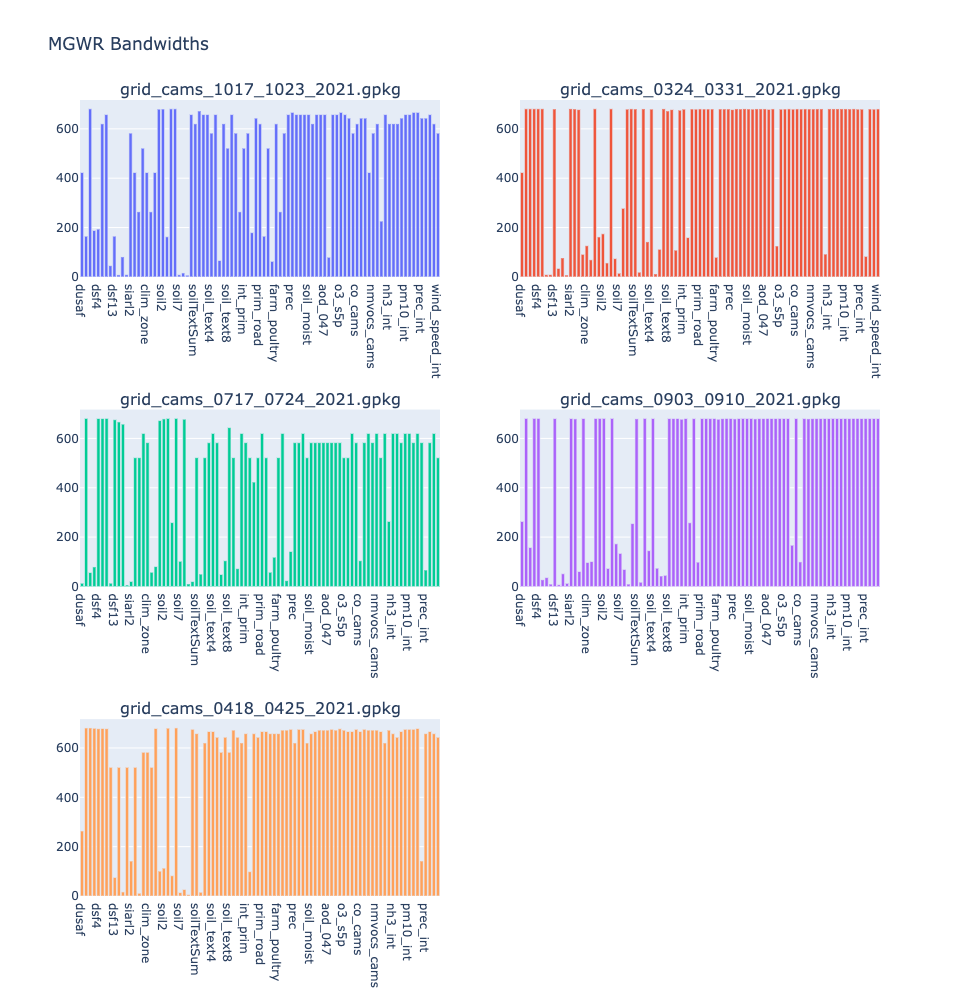

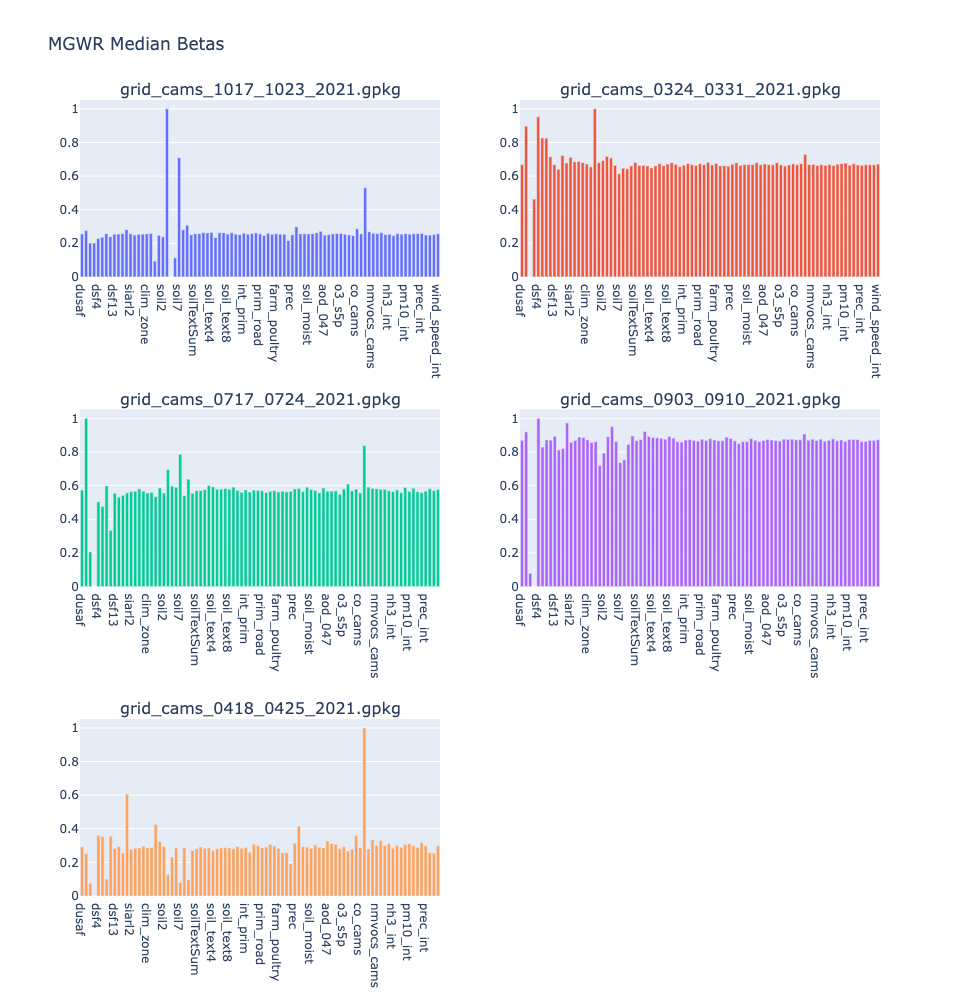

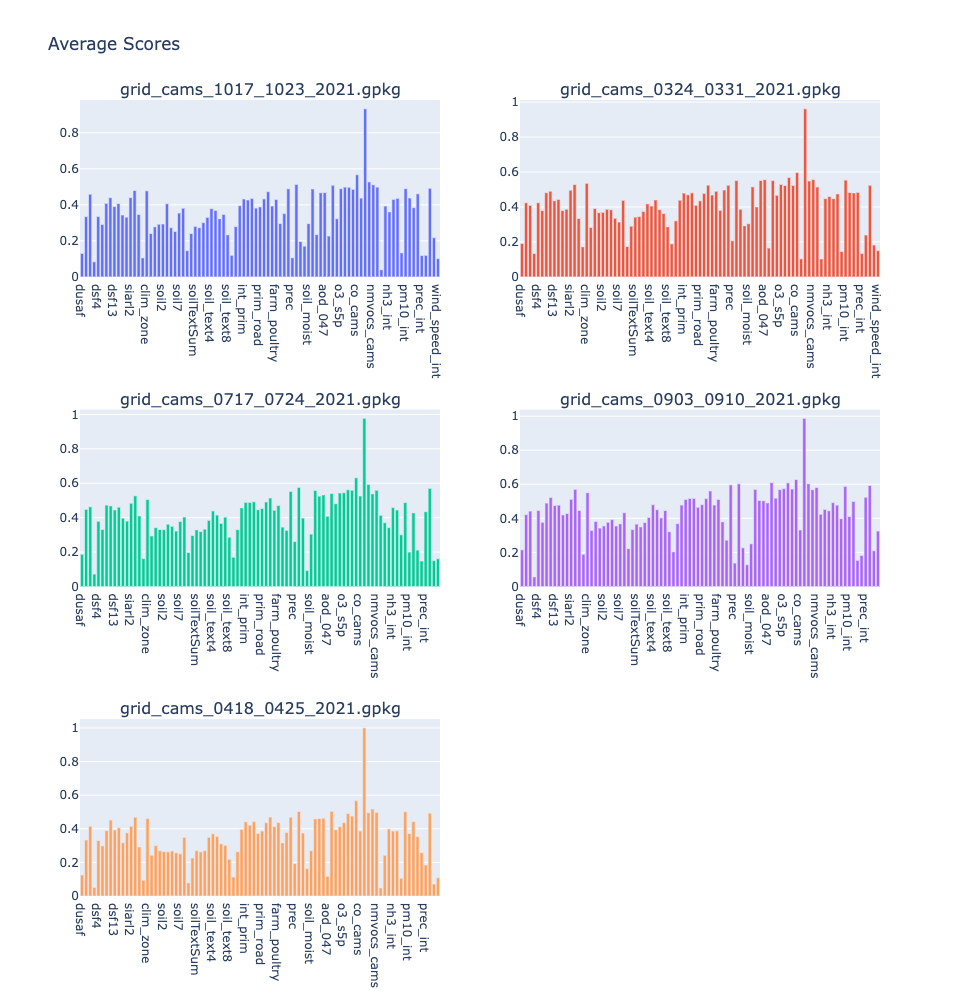

In [4]:
from scipy.linalg import LinAlgWarning

warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='mgwr')

bandwidths = []

for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]

    res = m.mgwr_beta(grid_data[index], target_variable.value, 1, geopackages[index])
    list(dataframes_results.values())[index]['MGWR Median Betas'] = m.NormalizeData(res['Betas Median'])
    bandwidths.append(res['Bandwidthds'])
    
    x = list(dataframes_results.values())[index].loc[:, list(dataframes_results.values())[index].columns != 'Features'].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    temp = pd.DataFrame(x_scaled)
    mean_results = temp.mean(axis=1)
    list(dataframes_results.values())[index]['Average Scores'] = mean_results

# MGWR Bandwidths bar plots
m.show_bars(list(dataframes_results.values())[0]['Features'], bandwidths, 'MGWR Bandwidths', geopackages)

res = []
for grid in geopackages:
        temp = (dataframes_results[grid])['MGWR Median Betas']
        temp = m.NormalizeData1D(temp)
        res.append(temp)

# MGWR Median(Betas) bar plots
m.show_bars(list(dataframes_results.values())[0]['Features'], res, 'MGWR Median Betas', geopackages)


res = []
for grid in geopackages:
        temp = (dataframes_results[grid])['Average Scores']
        res.append(temp)

# Average scores bar plots (including mgwr results)
m.show_bars(list(dataframes_results.values())[0]['Features'], res, 'Average Scores', geopackages)

### Variance Threshold

In [5]:
for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    m.variance_threshold(X, 0.1)  # 0.1 Th value

NameError: name 'X_notStand' is not defined

### Exhaustive feature selection

In [ ]:
for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    m.exhaustive_feature_selection(X, Y)

### Recursive feature selection

In [ ]:
for index in range(0,len(dataframes_results)):
    X = grid_data[index].loc[:, grid_data[index].columns != target_variable.value]
    coords = list(zip(X['lat_cen'], X['lng_cen']))
    X.pop('lat_cen')
    X.pop('lng_cen')
    Y = grid_data[index][target_variable.value]
    m.recursive_feature_selection(X, Y.astype(int), 10) # 10 = number of features